In [1]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch

import cooper

### Maximum entropy

This example is inspired by [this StackExchange question](https://datascience.stackexchange.com/questions/107366/how-do-you-solve-strictly-constrained-optimization-problems-with-pytorch).

>I am trying to solve the following problem using pytorch: given a six sided die whose
>average roll is known to be 4.5, what is the maximum entropy distribution for the faces?

In [2]:
class MaximumEntropy(cooper.ConstrainedMinimizationProblem):
    def __init__(self, mean_constraint):
        self.mean_constraint = mean_constraint
        super().__init__(is_constrained=True)

    def closure(self, probs):
        # Verify domain of definition of the functions
        assert torch.all(probs >= 0)

        # Negative signed removed since we want to *maximize* the entropy
        entropy = torch.sum(probs * torch.log(probs))

        # Entries of p >= 0 (equiv. -p <= 0)
        ineq_defect = -probs

        # Equality constraints for proper normalization and mean constraint
        mean = torch.sum(torch.tensor(range(1, len(probs) + 1)) * probs)
        eq_defect = torch.stack([torch.sum(probs) - 1, mean - self.mean_constraint])

        return cooper.CMPState(
            loss=entropy, eq_defect=eq_defect, ineq_defect=ineq_defect
        )

In [3]:
cmp = MaximumEntropy(mean_constraint=4.5)
formulation = cooper.LagrangianFormulation(cmp)

probs = torch.nn.Parameter(torch.rand(6))

primal_optimizer = cooper.optim.ExtraSGD([probs], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial(cooper.optim.ExtraSGD, lr=9e-3, momentum=0.7)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [4]:
state_history = cooper.StateLogger(
    save_metrics=["loss", "eq_defect", "eq_multipliers"]
)

for iter_num in range(5000):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, probs)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, probs)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(probs.data)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

print(cmp.state)

CMPState(loss=tensor(-1.6136, grad_fn=<SumBackward0>), ineq_defect=tensor([-0.0544, -0.0788, -0.1142, -0.1654, -0.2398, -0.3475],
       grad_fn=<NegBackward0>), eq_defect=tensor([3.6955e-06, 0.0000e+00], grad_fn=<StackBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


In [5]:
# True solution for mean=4.5
a = torch.tensor([0.05435, 0.07877, 0.1142, 0.1654, 0.2398, 0.3475])
-torch.sum(a * torch.log(a))

tensor(1.6136)

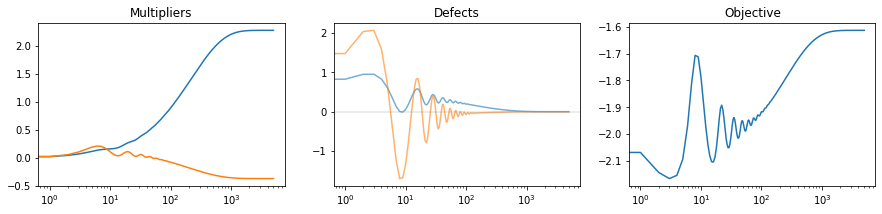

In [6]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()